In [ ]:
#default_exp ch01_problem02

Consider the so-called piston simulation function which was at one time a popular benchmark problem in the computer experiments literature. (That link, to Surjanovic and Bingham (2013)’s Virtual Library of Simulation Experiments (VLSE), provides references and further detail. VLSE is a great resource for test functions and computer simulation experiment data; there’s a page for the wing weight example as well.) Response  
C
(
x
)
  is the cycle time, in seconds, of the circular motion of a piston within a gas-filled cylinder, the configuration of which is described by seven-dimensional input vector  
x
=
(
M
,
S
,
V
0
,
k
,
P
0
,
T
a
,
T
0
)
 .

In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
import pyDOE
import GPy
import plotnine as pn

from surrogates import ch01_problem01

In [3]:
#export
def piston(M, S, V0, k, P0, Ta, T0):
    A = P0*S + 19.62*M - k*V0 / S
    V = (S / (2*k)) * (np.sqrt(A**2 + 4*k * (P0*V0 / T0) * Ta) - A)    
    sq_denom = k + S**2 * (P0*V0 / T0) * (Ta / V**2)
    return 2 * np.pi * np.sqrt(M / sq_denom)


def scale_to_range(v: pd.Series, target_min: float, target_max: float) -> pd.Series:
    vmin, vmax = v.min(), v.max()    
    return ((v - vmin) / (vmax - vmin)) * (target_max - target_min) + target_min


def scale_columns(df, stats_dict) -> None:    
    for var in df.columns:
        df[var] = df[var] + stats_dict[var]['baseline']
        df[var] = scale_to_range(
            df[var], 
            target_min=stats_dict[var]['minimum'],
            target_max=stats_dict[var]['maximum'])

In [4]:
rows = [
    ('M',  45,     30,    60),
    ('S',  0.0125, 0.005, 0.020),
    ('V0', 0.006,  0.002, 0.010),
    ('k',  3000,   1000,  5000),
    ('P0', 100000, 90000, 110000),
    ('Ta', 293,    290,   296),
    ('T0', 350,    340,   360)
]
ranges_df = pd.DataFrame(rows, columns=['var', 'baseline', 'minimum', 'maximum'])
variables = list(ranges_df['var'])

In [5]:
stats_dict = {}
for i, row in ranges_df.iterrows():
    stats = {}
    for name in ('baseline', 'minimum', 'maximum'):
        stats[name] = row[name]
    stats_dict[row['var']] = stats

In [6]:
baselines = dict([
    (var, baseline) for var, baseline in zip(ranges_df['var'], ranges_df['baseline'])])

In [7]:
baseline = piston(**baselines)

In [8]:
grid_matrix = pyDOE.lhs(len(variables), samples=1000)
grid_df = pd.DataFrame(grid_matrix, columns=variables)

SCALE_UP = True
if SCALE_UP:
    scale_columns(grid_df, stats_dict)

In [9]:
grid_df

,M,S,V0,k,P0,Ta,T0
0,34.099992,0.005521,0.008091,2994.976450,108011.508374,292.102877,343.748212
1,53.418735,0.005900,0.003413,2835.192837,92425.448946,293.766180,358.719284
2,49.582386,0.018427,0.009731,2021.090304,96593.133297,292.489081,359.396633
3,37.204823,0.012904,0.008975,1270.097996,100649.390725,291.780352,352.549648
4,35.486176,0.006339,0.006862,4595.784042,104516.059777,293.327088,343.438117
...,...,...,...,...,...,...,...
995,38.896045,0.012692,0.006961,1123.344594,92720.278560,294.460526,352.278149
996,48.977386,0.006438,0.006586,4281.913961,92464.159731,294.289315,353.297149
997,51.287210,0.013783,0.009365,4258.676640,101871.179111,291.912523,348.512648
998,36.013369,0.006249,0.005278,2444.273832,97609.841809,295.640328,354.215359


In [10]:
y_actual = grid_df.apply(lambda row: piston(**row), axis=1)
y_actual = y_actual.values.reshape((len(y_actual), 1))

In [21]:
kernel = GPy.kern.RBF(input_dim=len(variables), lengthscale=10)
model = GPy.models.GPRegression(grid_matrix, y_actual, kernel)
mean_fit, var_fit = model.predict(grid_matrix)
var_fit = [x[0] for x in var_fit]

In [39]:
from sklearn.ensemble import RandomForestRegressor
import forestci
model = RandomForestRegressor(n_estimators=1000, max_depth=4).fit(grid_matrix, y_actual.ravel())
mean_fit = model.predict(grid_matrix)
var_fit = forestci.random_forest_error(model, grid_matrix, grid_matrix)

In [23]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(grid_matrix, y_actual.ravel())
mean_fit = model.predict(grid_matrix)
resid = mean_fit - y_actual.ravel()
var_fit = resid.var()

In [40]:
fit_df = (
    pd.DataFrame(mean_fit, columns=['pred'])
    .assign(variance=var_fit,
            std=lambda d: np.sqrt(d['variance']),
            y=y_actual, 
            resid=lambda d: d['y'] - d['pred']))
ch01_problem01.attach_std(fit_df, var_fit)
fit_df

,pred,variance,std,y,resid,lb,ub
0,0.553061,0.002432,0.049316,0.622327,0.069266,0.503745,0.602377
1,0.578868,0.002548,0.050477,0.618070,0.039202,0.528391,0.629346
2,0.432255,0.002399,0.048975,0.461058,0.028803,0.383280,0.481230
3,0.530899,0.002432,0.049311,0.534088,0.003189,0.481588,0.580211
4,0.547180,0.002437,0.049365,0.513943,-0.033236,0.497815,0.596544
...,...,...,...,...,...,...,...
995,0.489057,0.002418,0.049176,0.490661,0.001604,0.439881,0.538233
996,0.606937,0.002494,0.049940,0.618051,0.011114,0.556997,0.656877
997,0.493996,0.002525,0.050248,0.518254,0.024258,0.443748,0.544243
998,0.649647,0.002941,0.054228,0.624891,-0.024756,0.595419,0.703874


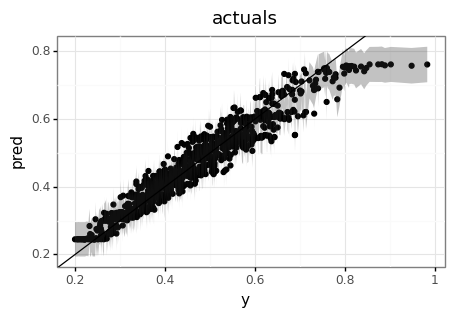

<ggplot: (8417213894244)>

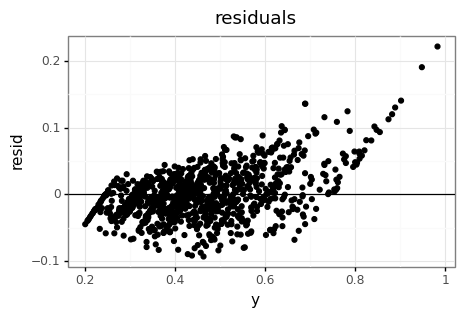

<ggplot: (8417205165635)>

In [41]:
ch01_problem01.plot_predictions(fit_df, (5, 3))

In [42]:
larger_grid_df = pd.DataFrame(pyDOE.lhs(len(variables), samples=10000*2),
                              columns=variables)
if SCALE_UP:
    scale_columns(larger_grid_df, stats_dict)
larger_grid_df['pred'] = model.predict(larger_grid_df.values)
# larger_grid_df['pred'] = grid_df.apply(lambda row: piston(**row), axis=1)

In [16]:
larger_grid_df.head()

,M,S,V0,k,P0,Ta,T0,pred
0,41.362449,0.012863,0.005864,4113.957008,98688.456230,295.873723,355.115760,0.419929
1,37.546452,0.006624,0.009554,3217.171734,106992.339431,295.049634,353.189948,0.687874
2,40.933389,0.013444,0.007332,3470.800825,108281.501638,294.533758,346.188972,0.455788
3,35.185576,0.013763,0.006585,1881.364777,109574.005829,290.559123,345.034435,0.429982
4,37.393594,0.011423,0.007098,1380.257099,107702.800583,291.419097,344.889006,0.519831


In [53]:
bins = 40 if SCALE_UP else 1
dfs = []
for i, vari in enumerate(variables):
    for j, varj in enumerate(variables):
        if j <= i:
            continue
        df = larger_grid_df[[vari, varj, 'pred']].copy()
        df.columns = ['val1', 'val2', 'pred']
        df['width'] = (df['val1'].max() - df['val1'].min()) / bins
        df['height'] = (df['val2'].max() - df['val2'].min()) / bins
        df['vari'] = vari
        df['varj'] = varj
        df['name'] = f"{vari}*{varj}"
        dfs.append(df)
long_grid_df = pd.concat(dfs)

In [54]:
long_grid_df

,val1,val2,pred,width,height,vari,varj,name
0,38.919070,0.019462,0.373386,0.75,0.000375,M,S,M*S
1,35.320403,0.006659,0.472033,0.75,0.000375,M,S,M*S
2,52.426446,0.010073,0.543897,0.75,0.000375,M,S,M*S
3,38.933040,0.014444,0.463930,0.75,0.000375,M,S,M*S
4,44.543370,0.007801,0.581987,0.75,0.000375,M,S,M*S
...,...,...,...,...,...,...,...,...
19995,293.085568,346.827316,0.519151,0.15,0.500000,Ta,T0,Ta*T0
19996,295.850913,347.535729,0.757545,0.15,0.500000,Ta,T0,Ta*T0
19997,290.548704,351.945991,0.403244,0.15,0.500000,Ta,T0,Ta*T0
19998,290.451725,340.035608,0.408359,0.15,0.500000,Ta,T0,Ta*T0


/opt/conda/lib/python3.8/site-packages/plotnine/facets/facet.py:549: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/opt/conda/lib/python3.8/site-packages/plotnine/facets/facet.py:555: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


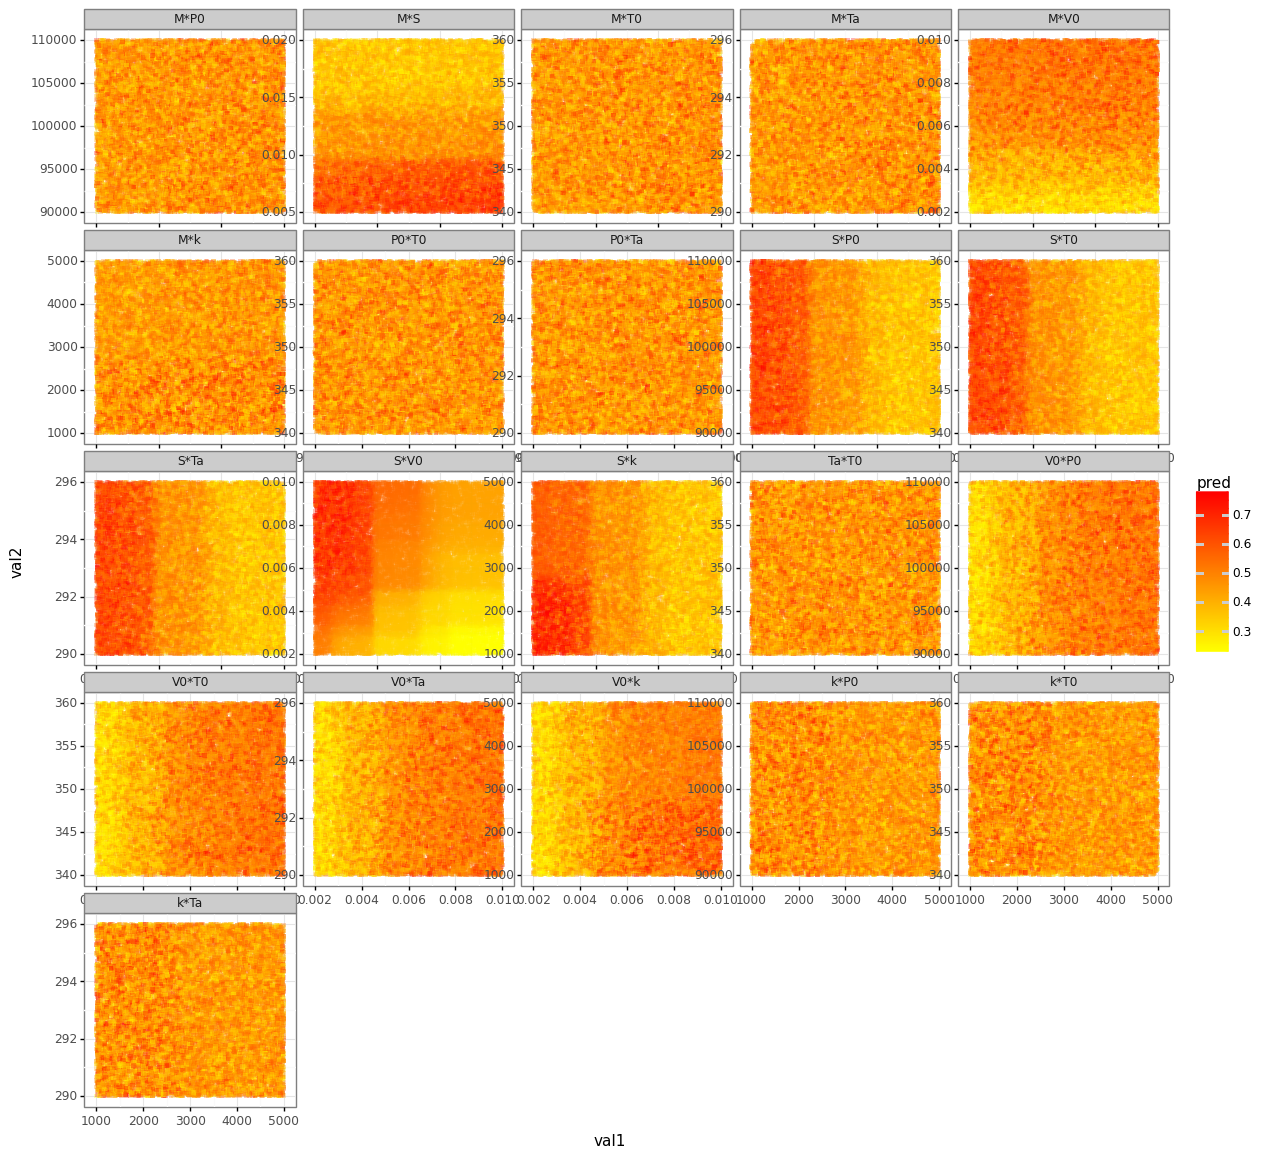

<ggplot: (8417198012344)>

In [55]:
(pn.ggplot(long_grid_df,#[long_grid_df['name'] == 'M*S'], 
           pn.aes(x='val1', y='val2', fill='pred')) +
 pn.geom_tile(pn.aes(width='width', height='height'), alpha=0.3) +
 pn.facet_wrap("name", scales="free") +
 pn.scale_fill_gradient(low='yellow', high='red') +
 pn.theme_bw() +
 pn.theme(figure_size=(14, 14)))